In [2]:
import tensorflow.compat.v1 as tf
import numpy as np
'''
初始化运算图，它包含了上节提到的各个运算单元，它将为W,x,b，h构造运算部件，并将它们连接
起来
'''
graph = tf.Graph()
#一次tensorflow代码的运行都要初始化一个session
session = tf.InteractiveSession(graph=graph)
'''
我们定义三种变量，一种叫placeholder，它对应输入变量，也就是上节计算图所示的圆圈部分,
他们的值在计算开始进行时才确定，这里对应x;
一种叫Variables,他们的值一开始就初始化，在后续运算中可以进行更改,这里对应W,b；
一种叫immutable tensor，这里对应h，它的值不允许我们直接修改
'''
x = tf.placeholder(shape=[1, 10], dtype=tf.float32, name='x')
#将W的各个分量初始化到[-0.1, 0.1]之间
W = tf.Variable(tf.random_uniform(shape=[10,5], minval=-0.1, 
                                  maxval=0.1, dtype=tf.float32), name='W')
#把b的各个分量初始化为0
b = tf.Variable(tf.zeros(shape=[5], dtype=tf.float32), name='b')
h = tf.nn.sigmoid(tf.matmul(x, W) + b)


2022-10-22 11:42:20.722006: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-22 11:42:20.832382: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-22 11:42:20.832428: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-22 11:42:20.832464: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ocsbesrhlrepo01.amr.corp.intel.com): /proc/driver/nvidia/version does not exist


In [3]:
 #使用run为各个变量分配内存并执行初始化操作
tf.global_variables_initializer().run()
h_eval = session.run(h, feed_dict={x: np.random.rand(1,10)})
#结束时一定要关闭session
session.close()


2022-10-22 11:42:24.178539: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


In [4]:
'''
先启动运算图和session
'''
graph = tf.Graph()
session = tf.InteractiveSession(graph = graph)

#将要读入文件名存储在一个队列中
filenames = ['./chap11/test%d.txt' %i for i in range(1,4)]
#下面建立一个输入管道
filename_queue = tf.train.string_input_producer(filenames, capacity = 3, 
                                                shuffle = True, 
                                                name = 'string_input_procucer')

for f in filenames:
  if not tf.gfile.Exists(f):
    raise ValueError('Failed to find file: ' + f)
  else:
    print('File %s found.' %f)

#构建reader将数据全部读入,tensorflow提供多种reader让我们读入不同格式数据
reader = tf.TextLineReader()
'''
调用reader.read读入数据，它一次读入一行,read返回数据结构(key, value),其中key对应读入数据的
文件名,value对应读入的一行数据
'''
key, value = reader.read(filename_queue, name='text_read_op')

'''
使用decoder将读入数据解码成指定数据结构，这里我们把读入的一行数据分解成多个数据列,由于每行包含
10个数字，因此对应10个数据列，因为一个文本包含5行数据，三个文本总共包含15行，因此一列数据包含
15个数字
'''
record_defaults = [[-1.0],[-1.0],[-1.0],[-1.0],[-1.0],[-1.0],
                   [-1.0],[-1.0],[-1.0],[-1.0],]
col1, col2, col3, col4, col5, col6, col7, col8, col9, col10 = tf.decode_csv(value, record_defaults = record_defaults)

#把数据列合在一起形成二维向量
features = tf.stack([col1,col2,col3,col4,col5,col6,col7,col8,col9,col10])
'''
在训练网络时，我们往往需要很多训练数据，当数据量庞大时，一次将数据全部读入内存是不现实的，
因此我们需要开辟一片缓存，然后将数据分批读入，capacity表示缓存最多能读入几条数据，
batch_size表示一次将相应条数据进行读取处理，
min_after_dequeue表示缓存中至少要读入几条数据,num_threads表示使用几个线程进行操作
'''
x = tf.train.shuffle_batch([features], batch_size=3, capacity=5,
                          name='data_batch', min_after_dequeue=1,
                          num_threads = 1)
#启动输入管道的运行流程
'''
由于数据读入和预处理是一种非常耗时的工作,tensorflow会创建多个线程同时对数据进行读取和处理，
coord对应所有处理线程的管理器，start_queue_runners则启动所有处理线程
'''
coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(coord=coord, sess=session)

W = tf.Variable(tf.random_uniform(shape=[10,5], minval=-0.1,
                                 maxval=0.1, dtype=tf.float32), name = 'W')
b = tf.Variable(tf.zeros(shape=[5], dtype=tf.float32), name='b')
h = tf.nn.sigmoid(tf.matmul(x, W) + b)

tf.global_variables_initializer().run()

for step in range(5):
  x_eval, h_eval = session.run([x, h])
  print('====step %d ====' %step)
  print('Evaluated data (x)')
  print(x_eval)
  print('Evaluated data (h)')
  print(h_eval)
  print('')
  
#终止数据管道线程
coord.request_stop()
coord.join(threads)
session.close()


Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(string_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(input_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensors(tensor).repeat(num_epochs)`.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.


ValueError: Failed to find file: test1.txt

In [ ]:
def  print_tensor(tensor):
  init = tf.global_variables_initializer()
  with tf.Session() as sess:
    sess.run(init)
    v = sess.run(tensor)
    print(v)  # will show you your variable.


In [4]:
ref = tf.Variable(tf.constant([1,9,3,10,5], dtype=tf.float32), name='scatter_value')
indices = [1,3]
updates = tf.constant([2,4], dtype = tf.float32)
tf_scatter_update = tf.scatter_update(ref, indices, updates,
                                     use_locking=None,
                                     name=None)

print_tensor(tf_scatter_update)


[1. 2. 3. 4. 5.]


In [5]:
'''
下面代码要构造一个4*3的二维向量，同时指定把updates变量对应的一维向量安置到indices指定位置，
也就是把[1,1,1]作为4*3二维向量的第1行，把[2,2,2]作为4*3向量的第3行，其他行自动初始化为0，
'''
indices=[[1], [3]]
updates = tf.constant([[1,1,1], [2,2,2]])
shape = [4,3]
tf_scatter_nd_1 = tf.scatter_nd(indices, updates, shape, name=None)
print_tensor(tf_scatter_nd_1)


[[0 0 0]
 [1 1 1]
 [0 0 0]
 [2 2 2]]


In [6]:
'''
构造一个4*3二维向量，然后把数值2插入到第1行第0列，
把数值1插入到第3行第2列，其他值初始化为0
'''
indices = [[1,0], [3,2]]
updates = tf.constant([2,1])
shape = [4,3]
tf_scatter_nd_2 = tf.scatter_nd(indices, updates, shape, name=None)
print_tensor(tf_scatter_nd_2)


[[0 0 0]
 [2 0 0]
 [0 0 0]
 [0 0 1]]


In [7]:
'''
下面代码把向量[1,2,3,4,5]中下标为1，4的分量提取出来，因此得到向量
[2,5]
'''
params = tf.constant([1,2,3,4,5], dtype=tf.float32)
indices = [1,4]
tf_gather = tf.gather(params, indices, validate_indices = True, name = None)
print_tensor(tf_gather)


[2. 5.]


In [8]:
'''
把二维向量中指定行提取出来
'''
params = tf.constant([[0,0,0], [1,1,1], [2,2,2],[3,3,3]])
indices = [[0], [2]]
tf_gather_nd = tf.gather_nd(params, indices, name=None)
print_tensor(tf_gather_nd)


[[0 0 0]
 [2 2 2]]


In [9]:
'''
构造一个4*4二维矩阵模拟图片
'''
x = tf.constant([[
    [[1], [2], [3], [4]],
    [[4], [3], [2], [1]],
    [[5], [6], [7], [8]],
    [[8], [7], [6], [5]]
]], dtype=tf.float32)

#定义用于做卷积操作的小矩阵
x_filter = tf.constant([
    [[[0.5]], [[1]]],
    [[[0.5]], [[1]]]
], dtype = tf.float32)

'''
把大矩阵切割成2*2小矩阵，然后与上面定义矩阵做乘机，
然后每次向右或向下平移一个单位后再做对应小矩阵的乘机运算
'''
#定义一次平移距离,四个分量分别为batch_stride,height_stride,width_stride,channles_stride]
x_strides = [1,1,1,1]
x_padding = 'VALID'
x_conv = tf.nn.conv2d(input = x, filter = x_filter,
                     strides = x_strides, padding = x_padding)
print_tensor(x_conv)


[[[[ 7.5]
   [ 7.5]
   [ 7.5]]

  [[13.5]
   [13.5]
   [13.5]]

  [[19.5]
   [19.5]
   [19.5]]]]


In [12]:
x = tf.constant([[
    [[1], [2], [3], [4]],
    [[4], [3], [2], [1]],
    [[5], [6], [7], [8]],
    [[8], [7], [5], [6]]
]], dtype = tf.float32)

'''
把矩阵分割成2*2小矩阵
'''
x_ksize = [1, 2, 2 ,1]
#做max pooling 时每次沿水平和竖直方向挪动2个单位
x_stride = [1, 2, 2, 1]
x_padding = 'VALID'

x_pool = tf.nn.max_pool(value = x, ksize = x_ksize,
                       strides = x_stride, padding = x_padding)
print_tensor(x_pool)

[[[[4.]
   [4.]]

  [[8.]
   [8.]]]]


In [8]:
'''
和方差:
MSE = (1^2 + 2^2 + 3^2 + 4^2) / 4 = 15
'''
x = tf.constant([[1,2], [3,4]], dtype = tf.float32)
mse = tf.nn.l2_loss(x)
print_tensor(mse)

'''
cross entropy 
H = -y*log(y') - (1-y)*log(1-y')
'''
y = tf.constant([[1,0],[0,1]], dtype = tf.float32)
y_hat = tf.constant([[3,2], [2,5]], dtype = tf.float32)
H = tf.nn.softmax_cross_entropy_with_logits_v2(logits = y_hat, labels = y)
print_tensor(H)

15.0
[0.31326166 0.04858733]


In [16]:
'''
使用梯度下降法对函数y=x^2求最小值，设置学习率为0.1
'''
x = tf.Variable(tf.constant(2.0, dtype=tf.float32), name = 'x')
y = x ** 2
minimize_op = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(y)
init = tf.global_variables_initializer()
with tf.Session() as session:
  session.run(init)
  for i in range(1000):
    session.run(minimize_op)
    print("step: ", i, " x: ", session.run(x), " y: ", session.run(y))
        


step:  0  x:  1.96  y:  3.8416002
step:  1  x:  1.9208001  y:  3.689473
step:  2  x:  1.8823841  y:  3.5433698
step:  3  x:  1.8447363  y:  3.403052
step:  4  x:  1.8078417  y:  3.2682915
step:  5  x:  1.7716849  y:  3.1388674
step:  6  x:  1.7362512  y:  3.0145683
step:  7  x:  1.7015262  y:  2.8951912
step:  8  x:  1.6674956  y:  2.7805417
step:  9  x:  1.6341457  y:  2.6704323
step:  10  x:  1.6014628  y:  2.5646832
step:  11  x:  1.5694336  y:  2.4631217
step:  12  x:  1.5380449  y:  2.3655822
step:  13  x:  1.507284  y:  2.2719052
step:  14  x:  1.4771384  y:  2.181938
step:  15  x:  1.4475956  y:  2.095533
step:  16  x:  1.4186437  y:  2.0125499
step:  17  x:  1.3902708  y:  1.932853
step:  18  x:  1.3624654  y:  1.8563119
step:  19  x:  1.335216  y:  1.7828019
step:  20  x:  1.3085117  y:  1.7122029
step:  21  x:  1.2823415  y:  1.6443996
step:  22  x:  1.2566947  y:  1.5792814
step:  23  x:  1.2315608  y:  1.5167421
step:  24  x:  1.2069296  y:  1.456679
step:  25  x:  1.182791

In [3]:
import tensorflow as tf

'''
首先将x 初始化为1，然后有两条语句，第一条作用是实现 x = x + 3, 第二条作用是实现 z = x * 4，
如果是串行执行，那么执行第一句后x变成4，执行第二句后z变成16,但tensorflow并不串行执行，
所以最终得到结果与上面预想不同
'''
x = tf.Variable(tf.constant(1.0), name = 'x')
x_assign = tf.assign(x, x+3)
z = x*4

init = tf.global_variables_initializer()
with tf.Session() as session:
  session.run(init)
  print('z = ', session.run(z))
  print('x = ', session.run(x))


z =  4.0
x =  1.0


In [5]:
import tensorflow as tf

'''
让x = x + 3 与 z = x * 4串行执行
'''
x = tf.Variable(tf.constant(1.0), name = 'x')

init = tf.global_variables_initializer()
with tf.Session() as session:
  session.run(init)
  with tf.control_dependencies([tf.assign(x, x+4)]):
    z = x * 4
  print('z = ', session.run(z))
  print('x = ', session.run(x))


z =  20.0
x =  5.0


In [36]:
def  simple_computation(w):
  x = tf.Variable(tf.constant(2.0, shape = None, dtype = tf.float32), 
                  name = 'simple_computation_x')
  y = tf.Variable(tf.constant(3.0, shape = None, dtype = tf.float32), 
                  name = 'simple_computation_y')
  z = x * 2 + y**3
  return z
  
with tf.Session() as session:
  z = simple_computation(2)
  init = tf.global_variables_initializer()
  session.run(init)
  res = session.run(z)
  print('simple computation result : ', res)

simple computation result :  31.0


In [40]:
with tf.Session() as session:
  for i in range(10):
    z = simple_computation(2)
    init = tf.global_variables_initializer()
    session.run(init)
    res = session.run(z)
  
for n in tf.get_default_graph().as_graph_def().node:
  if "simple_computation_x" in n.name:
    print(n.name)

simple_computation_x
simple_computation_x/Assign
simple_computation_x/read
simple_computation_x_1
simple_computation_x_1/Assign
simple_computation_x_1/read
simple_computation_x_2
simple_computation_x_2/Assign
simple_computation_x_2/read
simple_computation_x_3
simple_computation_x_3/Assign
simple_computation_x_3/read
simple_computation_x_4
simple_computation_x_4/Assign
simple_computation_x_4/read
simple_computation_x_5
simple_computation_x_5/Assign
simple_computation_x_5/read
simple_computation_x_6
simple_computation_x_6/Assign
simple_computation_x_6/read
simple_computation_x_7
simple_computation_x_7/Assign
simple_computation_x_7/read
simple_computation_x_8
simple_computation_x_8/Assign
simple_computation_x_8/read
simple_computation_x_9
simple_computation_x_9/Assign
simple_computation_x_9/read
simple_computation_x_10
simple_computation_x_10/Assign
simple_computation_x_10/read
simple_computation_x_11
simple_computation_x_11/Assign
simple_computation_x_11/read
simple_computation_x_12
simp

In [ ]:
import tensorflow as tf

def  simple_computation_reuse1(w):
  #把tf.Variable换成tf.get_variable
  x = tf.get_variable('x', initializer = tf.constant(1.0, 
                                                     shape = None, 
                                                     dtype = tf.float32))
  y = tf.get_variable('y', initializer = tf.constant(2.0,
                                                    shape = None,
                                                    dtype = tf.float32))
  z = x * w + y**2
  return z

def  simple_computation_reuse2(w):
  '''
  变量重用时初始化方式必须一致，例如上面变量x初始化值是1.0，重用时它的初始哈值也必须是1.0
  '''
  x = tf.get_variable('x', initializer = tf.constant(1.0,
                                                    shape = None,
                                                    dtype = tf.float32))
  y = tf.get_variable('y', initializer = tf.constant(2.0,
                                                    shape = None,
                                                    dtype = tf.float32))
  z = w*x*y
  return z



In [ ]:
'''
设定一个命名空间，在该空间里给定名字的变量只分配一次内存，我们可以通过变量名多次获取变量内存，
这样可以防止一个变量分配多次内存
'''
with tf.variable_scope('reuse_scope_exampleA', reuse = tf.AUTO_REUSE) as scope:
  #reuse_scope_exampleA/x,reuse_scope_exampleA/y
  z1 = simple_computation_reuse1(tf.constant(1.0, dtype = tf.float32))

with tf.variable_scope(scope, reuse = tf.AUTO_REUSE) as scope1:
  with tf.name_scope(scope1.original_name_scope):
    #下面调用会重用reuse_scope_exampleA/x,reuse_scope_exampleA/y
    z2 = simple_computation_reuse2(z1)
    
#再次重用my_reuse_scopeA/x,my_reuse_scopeA/y
with tf.variable_scope(scope, reuse = tf.AUTO_REUSE) as scope3:
  with tf.name_scope(scope3.original_name_scope):
    zz1 = simple_computation_reuse1(tf.constant(1.0, dtype = tf.float32))
    zz2 = simple_computation_reuse2(zz1)

In [ ]:
with tf.variable_scope('reuse_scope_exampleB', reuse = tf.AUTO_REUSE):
  #下面调用创建变量reuse_scope_exampleB/x,reuse_scope_exampleB/y
  a1 = simple_computation_reuse1(tf.constant(1.0, dtype = tf.float32))
with tf.variable_scope('my_reuse_scopeB/', reuse = tf.AUTO_REUSE):
  #下面调用重用reuse_scope_exampleB/x, reuse_scope_exampleB/y
  a2 = simple_computation_reuse2(a1)

In [133]:
with  tf.Session() as session:
  init = tf.global_variables_initializer()
  session.run(init)
  res = session.run([z1, z2, z2])
    

#把含有scope或scopeB的变量打印出，看看他们是否只有一份
for n in tf.get_default_graph().as_graph_def().node:
  if "reuse_scope_exampleA" in n.name or 'reuse_scope_exampleB' in n.name:
    print(n.name)

reuse_scope_exampleA/Const
reuse_scope_exampleA/Const_1
reuse_scope_exampleA/x
reuse_scope_exampleA/x/Assign
reuse_scope_exampleA/x/read
reuse_scope_exampleA/Const_2
reuse_scope_exampleA/y
reuse_scope_exampleA/y/Assign
reuse_scope_exampleA/y/read
reuse_scope_exampleA/mul
reuse_scope_exampleA/pow/y
reuse_scope_exampleA/pow
reuse_scope_exampleA/add
reuse_scope_exampleA/Const_3
reuse_scope_exampleA/Const_4
reuse_scope_exampleA/mul_1
reuse_scope_exampleA/mul_2
reuse_scope_exampleA/Const_5
reuse_scope_exampleA/Const_6
reuse_scope_exampleA/Const_7
reuse_scope_exampleA/mul_3
reuse_scope_exampleA/pow_1/y
reuse_scope_exampleA/pow_1
reuse_scope_exampleA/add_1
reuse_scope_exampleA/Const_8
reuse_scope_exampleA/Const_9
reuse_scope_exampleA/mul_4
reuse_scope_exampleA/mul_5
reuse_scope_exampleB/Const
reuse_scope_exampleB/Const_1
reuse_scope_exampleB/x
reuse_scope_exampleB/x/Assign
reuse_scope_exampleB/x/read
reuse_scope_exampleB/Const_2
reuse_scope_exampleB/y
reuse_scope_exampleB/y/Assign
reuse_scope

In [2]:
!pip install keras

In [ ]:
import tensorflow as tf
from keras.datasets import mnist
import numpy as np

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_num = train_images.shape[0]
rows = train_images.shape[1]
cols = train_images.shape[2]
test_num = test_images.shape[0]

train_images = train_images.reshape(train_num, rows * cols)
test_images = test_images.reshape(test_num, rows * cols)

train_images = (train_images - np.mean(train_images)) / np.std(train_images)
test_images = (test_images - np.mean(test_images)) / np.std(test_images)



In [ ]:
WEIGHTS = "weights"
BIAS = "bias"

batch_size = 100
img_width, img_height = 28, 28
input_size = img_width * img_height
num_labels = 10
tf.reset_default_graph()

#定义接收图片和图片标签的向量
tf_inputs = tf.placeholder(shape=[batch_size, input_size], dtype = tf.float32,
                          name = 'inputs')
tf_labels = tf.placeholder(shape=[batch_size, num_labels], dtype = tf.float32,
                          name = 'labels')

In [ ]:
'''
我们构建的网络有三层，前两层是全连接层，最后一层含有10个节点，每个节点输出当前图片对应数字的概率
'''
def  define_networks():
  with tf.variable_scope('layer1'):
    '''
    第一层网络有500个节点，由于一张图片相当于28*28的二维数组，因此输入层和第一层网络在全连接
    情况下，有(28*28 = 784)*500个链路参数，他们对应一个[784, 500]的二维向量
    '''
    tf.get_variable(WEIGHTS, shape=[input_size, 500], 
                    initializer = tf.random_uniform_initializer(0, 0.02))
    tf.get_variable(BIAS, shape=[500], 
                    initializer = tf.random_uniform_initializer(0, 0.01))
    
  with tf.variable_scope('layer2'):
    '''
    第二层网络有250个节点，第一层与第二层在全连接情况下有500*250个链路参数，对应[500, 250]
    的二维向量
    '''
    tf.get_variable(WEIGHTS, shape = [500, 250],
                   initializer = tf.random_uniform_initializer(0, 0.02))
    tf.get_variable(BIAS, shape = [250], 
                   initializer = tf.random_uniform_initializer(0, 0.01))
    
  with tf.variable_scope('layer3'):
    '''
    第三层只有10个节点，第二层与第三层在全连接情况下有250*10个链路参数，对应[250,10]
    的二维向量
    '''
    tf.get_variable(WEIGHTS, shape = [250, 10], 
                   initializer = tf.random_uniform_initializer(0, 0.02))
    tf.get_variable(BIAS, shape = [10],
                   initializer = tf.random_uniform_initializer(0, 0.01))
    

In [ ]:
'''
设置网络层的激活函数
'''
def  define_activations(x):
  #第一层使用relu激活函数
  with tf.variable_scope('layer1', reuse = tf.AUTO_REUSE):
    w, b = tf.get_variable(WEIGHTS), tf.get_variable(BIAS)
    tf_h1 = tf.nn.relu(tf.matmul(x, w) + b, name = 'hidden1')
    
  with tf.variable_scope('layer2', reuse = tf.AUTO_REUSE):
    #第二层使用relu激活函数
    w, b = tf.get_variable(WEIGHTS), tf.get_variable(BIAS)
    tf_h2 = tf.nn.relu(tf.matmul(tf_h1, w) + b, name = 'hidden2')
    
  with tf.variable_scope('layer3', reuse = tf.AUTO_REUSE):
    #第三层使用先不使用激活，直接把结果输出
    w, b = tf.get_variable(WEIGHTS), tf.get_variable(BIAS)
    tf_logits = tf.nn.bias_add(tf.matmul(tf_h2, w), b, name = 'logits')
    
  return tf_logits

In [ ]:
define_networks()

logits = define_activations(tf_inputs)
#定义损失函数
softmax = tf.nn.softmax_cross_entropy_with_logits_v2(logits = logits, labels = 
                                                    tf_labels)
tf_loss = tf.reduce_mean(softmax)
#使用梯度下降法调整网络参数
tf_loss_minimize = tf.train.MomentumOptimizer(momentum=0.9, 
                                              learning_rate = 0.01).minimize(tf_loss)
#定义网络对输入图片的判断结果
tf_predictions = tf.nn.softmax(define_activations(tf_inputs))

In [91]:
#启动训练流程
session = tf.InteractiveSession()
tf.global_variables_initializer().run()

NUM_EPOCHS = 50
def  accuracy(predictions, labels):
  #统计判断结果的准确率
  return np.sum(np.argmax(predictions, axis = 1).flatten() == labels.flatten()) / batch_size

test_accuracy_over_time = []
train_loss_over_time = []

for epoch in range(NUM_EPOCHS):
  train_loss = []
  for step in range(train_images.shape[0] // batch_size):
    #将标签转换为One-hot-vector
    labels_one_hot = np.zeros((batch_size, num_labels), dtype = np.float32)
    labels_one_hot[np.arange(batch_size), 
                   train_labels[step*batch_size: (step+1)*batch_size]] = 1.0
    
    if epoch == 0 and step == 0:
      print('one hot labels:')
      print(labels_one_hot[:10])
      print()
    
    #执行训练流程
    loss, _ = session.run([tf_loss, tf_loss_minimize], feed_dict = {
        tf_inputs: train_images[step*batch_size : (step+1)*batch_size, :],
        tf_labels: labels_one_hot
    })
    train_loss.append(loss)
  
  test_accuracy = []
  #测试网络训练效果
  for step in range(test_images.shape[0] // batch_size):
    test_predictions = session.run(tf_predictions ,
                                   feed_dict = {tf_inputs: 
                                   test_images[step*batch_size : (step+1)*batch_size, :]})
    
    batch_test_accuracy = accuracy(test_predictions, test_labels[step*batch_size:
                                                                (step+1)*batch_size])
    test_accuracy.append(batch_test_accuracy)
  
  print("Average train loss for the %d epoch: %.3f\n" % (epoch+1, np.mean(train_loss)))
  train_loss_over_time.append(np.mean(train_loss))
  print('\tAverage test accuracy for the %d epoch: %.2f\n' % (epoch+1, np.mean(test_accuracy) * 100.0))
  test_accuracy_over_time.append(np.mean(test_accuracy)*100)
  
session.close()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


one hot labels:
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

Average train loss for the 1 epoch: 1.763

	Average test accuracy for the 1 epoch: 51.28

Average train loss for the 2 epoch: 0.837

	Average test accuracy for the 2 epoch: 85.90

Average train loss for the 3 epoch: 0.393

	Average test accuracy for the 3 epoch: 90.84

Average train loss for the 4 epoch: 0.288

	Average test accuracy for the 4 epoch: 91.62

Average train loss for the 5 epoch: 0.244

	Average test accuracy for the 5 epoch: 92.34

Average train loss for the 6 epoch: 0.217

	Average test accuracy for the 6 epoch: 93.39

Average train loss for the 7 epoch: 0.196

	Average test accuracy for the 7 epoch: 93.95

Average train loss for

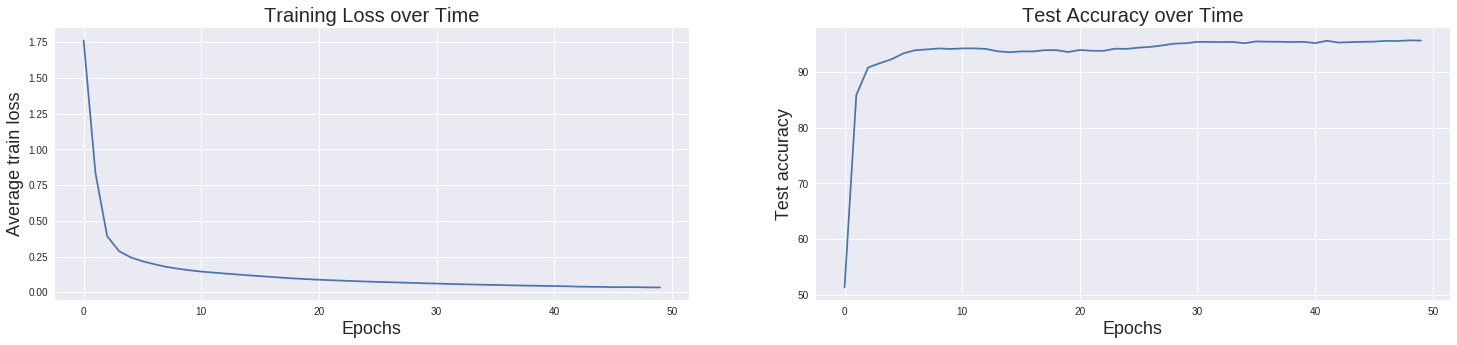

In [92]:
import matplotlib.pyplot as plt

x_axis = np.arange(len(train_loss_over_time))

fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(w=25,h=5)
ax[0].plot(x_axis, train_loss_over_time)
ax[0].set_xlabel('Epochs',fontsize=18)
ax[0].set_ylabel('Average train loss',fontsize=18)
ax[0].set_title('Training Loss over Time',fontsize=20)
ax[1].plot(x_axis, test_accuracy_over_time)
ax[1].set_xlabel('Epochs',fontsize=18)
ax[1].set_ylabel('Test accuracy',fontsize=18)
ax[1].set_title('Test Accuracy over Time',fontsize=20)
fig.savefig('mnist_stats.jpg')